In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

In [2]:
!pip install watermark --quiet
%load_ext watermark
%watermark -a 'Anrei Sech' -v -p torch

     |████████████████████████████████| 1.6 MB 33.4 MB/s 
Author: Anrei Sech

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 7.9.0

torch: 1.12.1+cu113



In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 32
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)

# Loading the data

In [4]:
transformer = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)), 
                                              torchvision.transforms.ToTensor()])

In [5]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [6]:
train_data = torchvision.datasets.ImageFolder("/drive/My Drive/DL/data/hymenoptera_data/train", transformer)
val_data = torchvision.datasets.ImageFolder("/drive/My Drive/DL/data/hymenoptera_data/val", transformer)

In [7]:
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
NUM_CLASSES = len(train_data.classes)
print(train_data.classes)

['ants', 'bees']


## Calculating mean and standard deviation

In [9]:
def get_mean_and_std(loader):
    mean = std = total_images = 0
    for images, _ in loader:
        images = images.view(images.shape[0], images.shape[1], -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images += images.shape[0]
    mean /= total_images
    std /= total_images
    return mean, std

In [10]:
mean, std = get_mean_and_std(train_loader)
print(mean, std)

tensor([0.5143, 0.4760, 0.3487]) tensor([0.2196, 0.2114, 0.2079])


## Applying mean and std to normalize images and augmentation

In [11]:
train_transformer = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)),
                                               torchvision.transforms.AutoAugment(torchvision.transforms.AutoAugmentPolicy.IMAGENET),
                                               torchvision.transforms.ToTensor(), 
                                               torchvision.transforms.Normalize(mean, std)])

In [12]:
test_transformer = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)),
                                               torchvision.transforms.ToTensor(), 
                                               torchvision.transforms.Normalize(mean, std)])

In [13]:
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=BATCH_SIZE, shuffle=False)

image.shape: torch.Size([32, 3, 224, 224])


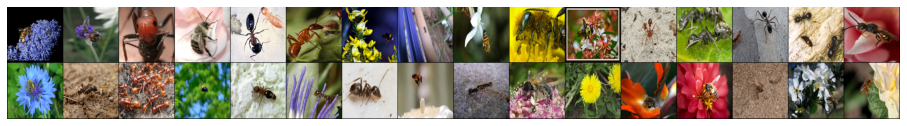

In [14]:
from torchvision.utils import make_grid
for images, _ in train_loader:
  print('image.shape:', images.shape)
  plt.figure(figsize=(16,8))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow=16).permute(1,2,0))
  break

# Pretrained models

In [24]:
resNetModel = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)

In [25]:
vggModel = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT)

## ResNET

In [41]:
model = resNetModel

In [42]:
for param in model.parameters():
    param.requires_grad = False

In [43]:
num_features = model.fc.in_features

In [44]:
model.fc = nn.Linear(num_features, 2)

In [45]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [46]:
num_epochs = 20
for epoch in range(num_epochs):
    for index, (images, target) in enumerate(train_loader):
        outputs = model(images)
        loss = loss_function(outputs, target)
        if index % 10 == 1:
            print(f'At epoch {epoch} and at index {index}, the loss is {loss}')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

At epoch 0 and at index 1, the loss is 0.564474880695343
At epoch 1 and at index 1, the loss is 0.7313333749771118
At epoch 2 and at index 1, the loss is 0.48499828577041626
At epoch 3 and at index 1, the loss is 0.6885608434677124
At epoch 4 and at index 1, the loss is 0.5831272006034851
At epoch 5 and at index 1, the loss is 0.6964967250823975
At epoch 6 and at index 1, the loss is 0.542068362236023
At epoch 7 and at index 1, the loss is 0.5130374431610107
At epoch 8 and at index 1, the loss is 0.7382315397262573
At epoch 9 and at index 1, the loss is 0.6696697473526001
At epoch 10 and at index 1, the loss is 0.7550256252288818
At epoch 11 and at index 1, the loss is 0.6145371794700623
At epoch 12 and at index 1, the loss is 0.4805971086025238
At epoch 13 and at index 1, the loss is 0.6540644764900208
At epoch 14 and at index 1, the loss is 0.5526270270347595
At epoch 15 and at index 1, the loss is 0.6064654588699341
At epoch 16 and at index 1, the loss is 0.604199230670929
At epoch 

## Running against validation set

In [47]:
with torch.no_grad():
    total_records = correct_records = 0
    for index, (images, target) in enumerate(val_loader):
        output = model(images)
        _, prediction = torch.max(output, 1)
        accuracy = torch.sum(prediction == target)
        correct_records += accuracy
        total_records += images.shape[0]
    print(f'Total records {total_records} and correct records is {correct_records}')
    print(f'Total accuracy is {(correct_records / total_records) * 100}')

Total records 153 and correct records is 77
Total accuracy is 50.32680130004883


# VGG

In [48]:
model = vggModel # torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT)

In [49]:
for param in model.parameters():
    param.requires_grad = False

In [50]:
model.classifier[6] = nn.Linear(4096, 2)

In [51]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [52]:
num_epochs = 20
for epoch in range(num_epochs):
    for index, (images, target) in enumerate(train_loader):
        outputs = model(images)
        loss = loss_function(outputs, target)
        if index % 10 == 1:
            print(f'At epoch {epoch} and at index {index}, the loss is {loss}')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

At epoch 0 and at index 1, the loss is 2822009.75
At epoch 1 and at index 1, the loss is 1743121.125
At epoch 2 and at index 1, the loss is 704519.9375
At epoch 3 and at index 1, the loss is 263101.40625
At epoch 4 and at index 1, the loss is 610469.0625
At epoch 5 and at index 1, the loss is 154323.0
At epoch 6 and at index 1, the loss is 148878.25
At epoch 7 and at index 1, the loss is 189758.625
At epoch 8 and at index 1, the loss is 210859.5625
At epoch 9 and at index 1, the loss is 165532.84375
At epoch 10 and at index 1, the loss is 143664.796875
At epoch 11 and at index 1, the loss is 296021.78125
At epoch 12 and at index 1, the loss is 163821.21875
At epoch 13 and at index 1, the loss is 207058.25
At epoch 14 and at index 1, the loss is 102617.3515625
At epoch 15 and at index 1, the loss is 202669.171875
At epoch 16 and at index 1, the loss is 245949.078125
At epoch 17 and at index 1, the loss is 438245.4375
At epoch 18 and at index 1, the loss is 466847.40625
At epoch 19 and a

In [53]:
with torch.no_grad():
    total_records = correct_records = 0
    for index, (images, target) in enumerate(val_loader):
        output = model(images)
        _, prediction = torch.max(output, 1)
        accuracy = torch.sum(prediction == target)
        correct_records += accuracy
        total_records += images.shape[0]
    print(f'Total records {total_records} and correct records is {correct_records}')
    print(f'Total accuracy is {(correct_records / total_records) * 100}')

Total records 153 and correct records is 67
Total accuracy is 43.79085159301758
